In [1]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt

import pods, pandas as pd, numpy as np, seaborn as sns, itertools

import GPy
from topslam import ManifoldCorrectionTree, ManifoldCorrectionKNN

In [2]:
data = pods.datasets.singlecell()
expr = data['Y']
labels = data['labels']

In [3]:
import cPickle as pickle
with open('Guo/singlecellGuo.pickle', 'r') as f:
    m = GPy.load(f)

In [4]:
ulabels = []
for l in labels:
    if l not in ulabels:
        ulabels.append(l)

sort = np.empty(labels.shape, dtype=int)
curr_i = 0
for i, l in enumerate(ulabels):
    hits = labels==l
    sort[range(curr_i, curr_i+hits.sum())] = np.where(hits)
    curr_i += hits.sum()

# Model training
Dont run, as we have pickled the training model before.

In [5]:
if 0:
    #m = GPy.models.MRD([y[:,None] for y in genes.values.T], 5, num_inducing=40)
    m = GPy.models.BayesianGPLVM((expr.values), 5, num_inducing=40)
    m.likelihood.fix(m.Y.var()/100.)
    m.X.variance.fix(.1)
    m.kern.lengthscale.fix()
    m.optimize(messages=1, max_iters=600)
    m.unfix()
    m.optimize(messages=1, max_iters=3e4)
    m.Z.randomize()
    m.optimize(messages=1, max_iters=3e4)
    #m.pickle('Guo/singlecell.pickle')

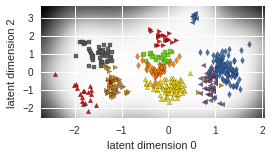

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
m.plot_latent(labels=labels, marker='<>sd^', ax=ax, legend=False)
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#fig.tight_layout()

In [ ]:
GPy.plotting.change_plotting_library('matplotlib')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
m.plot_magnification(labels=labels, marker='<>sd^', ax=ax, legend=False, plot_scatter=False)
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#fig.tight_layout()

# Distance Histograms

In [6]:
from topslam.plotting import plot_dist_hist

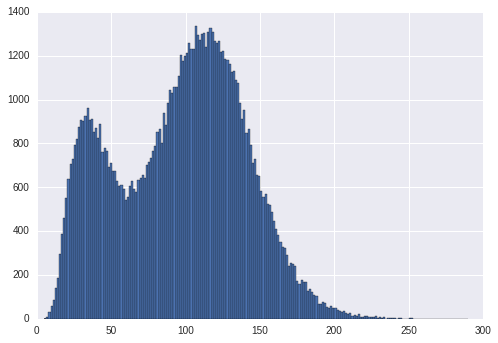

In [7]:
plot_dist_hist(m.Y)

# Manifold Correction and Label Definitions

In [8]:
import networkx as nx

mc = ManifoldCorrectionTree(m)
mknn = ManifoldCorrectionKNN(m, 4, include_mst=False)

msi = m.get_most_significant_input_dimensions()[:2]
Xmc = m.X.mean[:,msi]
posmc = dict((i, Xmc[i]) for i in range(Xmc.shape[0]))

label_dict = dict(zip(range(labels.shape[0]), labels))

begin = 3

pt = mc.graph_distances
pseudo_time = mc.get_pseudo_time(begin)

In [9]:
# Clean the labels from PCA approach errors:
# Get the label_positions, which are the means for points with the same labels (euclidean)
from topslam.pseudo_time.distance_correction import _get_label_pos
label_pos, ptpos, ptmi, ptma = _get_label_pos(Xmc.values, pseudo_time, labels, ulabels)

# Get the centroids for the label_positions (closest points to the center), again euclidean
df = pd.DataFrame(np.zeros((Xmc.shape[0], len(ulabels))), columns=ulabels)
for l in ulabels:
    points = Xmc.values
    df[l] = np.sqrt(np.sum((points - label_pos[l][None])**2, -1))
centroids = df.idxmin(0).to_dict()

# Now we go along the landscape to the closest centroid and take over its label
df = pd.DataFrame(np.zeros((Xmc.shape[0], len(ulabels))), columns=ulabels)
for i in range(Xmc.shape[0]):
    for l in ulabels:
        df.loc[i,l] = pt[i, centroids[l]]

labels_corrected = df.idxmin(1).values

In [70]:
def convert_to_landscape_colors(a):
    from matplotlib.colors import LinearSegmentedColormap
    colors = np.asarray([
                (203,227,193),
                (232,222,187),
                (203,227,193),
                (232,222,187),
                (241,238,233),
                (203,227,193),
                (175,175,151), 
                (232,222,187),
                ], dtype=float)/255.
    datamapping = np.exp(-10*np.linspace(0,1,len(colors)))[::-1]
    datamapping -= datamapping.min()
    datamapping /= datamapping.max()
    cmap = LinearSegmentedColormap.from_list('cities', [(x,c) for x,c in zip(datamapping, colors)])
    return cmap(a)

In [71]:
sns.set_style('white')

import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [72]:
mi, ma = Xgrid.min(0), Xgrid.max(0) 
wadd_figsize = (5,3)

In [83]:
ax.text?

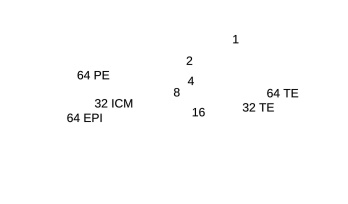

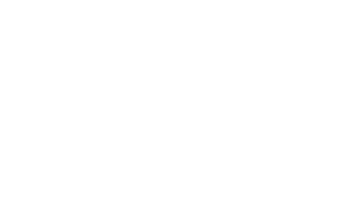

In [93]:
import matplotlib.patheffects as path_effects

# Labels:
fig, ax = plt.subplots(figsize=wadd_figsize)
label_pos, col, _mi, _ma = _get_label_pos(Xmc, pt, labels_corrected, ulabels)
for l in ulabels:
    p = label_pos[l]
    t = ax.text(p[0], p[1], l, alpha=1, ha='center', va='center', 
                color='#000000', fontsize=12,
               fontdict=dict(family='sans-serif'))
    t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='#eeeeee'),
                       path_effects.Normal()])
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourLabels.pdf', bbox='tight', transparent=True)


# Labels:
fig, ax = plt.subplots(figsize=wadd_figsize)
label_pos, col, _mi, _ma = _get_label_pos(Xmc, pt, labels_corrected, ulabels)
for l in ulabels:
    p = label_pos[l]
    ax.text(p[0], p[1], l, alpha=1, ha='center', va='center', color='w', fontsize=13)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourLabelsBack.pdf', bbox='tight', transparent=True)

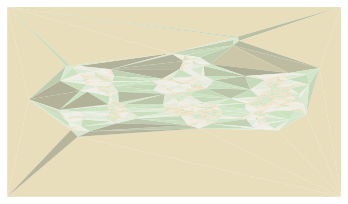

In [74]:
# Triangulation:
fig, ax = plt.subplots(figsize=wadd_figsize)
from scipy.spatial import Voronoi, Delaunay

points = Xmc.values.copy()
points = np.r_[points, mi[None], ma[None], [[mi[0],ma[1]]], [[ma[0],mi[1]]]]

tri = Delaunay(points)
polys = []
areas = []
for region in tri.simplices:
    if len(region):# and not (-1 in region):
        ta = tri.points[region]
        a, b, c = ta
        areas.append(np.abs(np.cross((b-a),(c-a)))/2)
        polys.append(Polygon(ta))
areas = np.asarray(areas)
ax.add_collection(PatchCollection(polys, alpha=1, linewidths=0, edgecolors='.7', facecolors=convert_to_landscape_colors(areas), zorder=-2))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourTriangulation.pdf', bbox='tight', transparent=True)

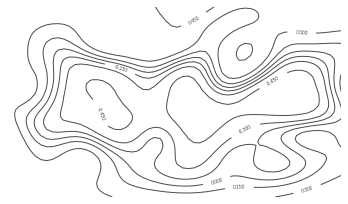

In [75]:
# Contour
fig, ax = plt.subplots(figsize=wadd_figsize)
CS = ax.contour(r(Xgrid[:,0]), r(Xgrid[:,1]), r(wad), linewidths=1, 
                negative_linestyle='solid', 
                colors='.3', zorder=-1)
ax.clabel(CS, fontsize=5, inline=1)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourContour.pdf', bbox='tight', transparent=True)

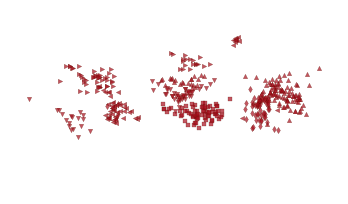

In [76]:
fig, ax = plt.subplots(figsize=wadd_figsize)

markers = itertools.cycle(list('<>^vsd'))

for l in ulabels:
    fil = labels==l
    ax.scatter(Xmc[fil,0], Xmc[fil,1], marker=next(markers), alpha=.7, facecolor='#a80f1e', edgecolor='#5d0e00', linewidth=.3)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourHouses.pdf', bbox='tight', transparent=True)

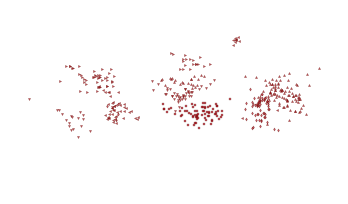

In [77]:
fig, ax = plt.subplots(figsize=wadd_figsize)

markers = itertools.cycle(list('<>^vsd'))

for l in ulabels:
    fil = labels==l
    ax.scatter(Xmc[fil,0], Xmc[fil,1], marker=next(markers), alpha=.7, facecolor='#a80f1e', edgecolor='#5d0e00', linewidth=.3, s=5)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourHousesSmall.pdf', bbox='tight', transparent=True)

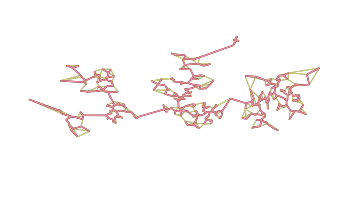

In [78]:
fig, ax = plt.subplots(figsize=wadd_figsize)
knn = nx.Graph(mknn.graph)
nx.draw_networkx_edges(knn, posmc,  
                       ax=ax, alpha=1, width=.8, 
                       edge_color='#545814')
nx.draw_networkx_edges(knn, posmc,  
                       ax=ax, alpha=1, width=.6, 
                       edge_color='#EFF392')

test = nx.Graph(mc.minimal_spanning_tree)
nx.draw_networkx_edges(test, posmc,  
                       ax=ax, alpha=1, width=1.5, 
                       edge_color='#740F22')
nx.draw_networkx_edges(test, posmc,  
                       ax=ax, alpha=1, width=1.3, 
                       edge_color='#E792A2')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourStreetsSmall.pdf', bbox='tight', transparent=True, alpha=.5)

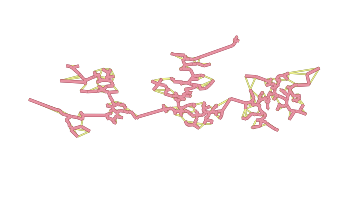

In [79]:
fig, ax = plt.subplots(figsize=wadd_figsize)
knn = nx.Graph(mknn.graph)
nx.draw_networkx_edges(knn, posmc,  
                       ax=ax, alpha=1, width=1.4, 
                       edge_color='#545814')
nx.draw_networkx_edges(knn, posmc,  
                       ax=ax, alpha=1, width=1.2, 
                       edge_color='#EFF392')

test = nx.Graph(mc.minimal_spanning_tree)
nx.draw_networkx_edges(test, posmc,  
                       ax=ax, alpha=1, width=3, 
                       edge_color='#740F22')
nx.draw_networkx_edges(test, posmc,  
                       ax=ax, alpha=1, width=2.7, 
                       edge_color='#E792A2')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])
fig.tight_layout()
fig.savefig('../diagrams/Guo/WaddingtonLandscapeContourStreets.pdf', bbox='tight', transparent=True)

# Extract specific timelines (to different 64 cell stages)

In [ ]:
mst = mc.minimal_spanning_tree
mst_struct = mc.distances_in_structure

In [ ]:
idx_TE = labels=='64 TE'
idx_PE = labels=='64 PE'
idx_EPI = labels=='64 EPI'

In [ ]:
nx_mst = nx.Graph(mst)
nx.set_node_attributes(nx_mst, 'label', label_dict)

In [ ]:
predecessors = mc._predecessors

In [ ]:
m.kern.plot_ARD()

In [ ]:
plt.close('all')

In [ ]:
def extract_shortest_path(start, stop, preds):
    path = []
    while stop != start:
        path.append(stop)
        stop = preds[stop]
    path.append(stop)
    return path[::-1]

In [ ]:
random_64epi = np.where(labels == '64 EPI')[0][10]#np.random.choice(np.where(labels == '64 EPI')[0])
sp0to64epi = extract_shortest_path(begin, random_64epi, predecessors[begin])

In [ ]:
random_64te = np.where(labels == '64 TE')[0][10]#np.random.choice(np.where(labels == '64 TE')[0])
sp0to64te = extract_shortest_path(begin, random_64te, predecessors[begin])

In [ ]:
random_64pe = np.where(labels == '64 PE')[0][30]#np.random.choice(np.where(labels == '64 PE')[0])
sp0to64pe = extract_shortest_path(begin, random_64pe, predecessors[begin])

In [ ]:
%run plot_definitions_datasets.py

# plot widened subgraphs:
fig, ax = plt.subplots(figsize=(5,2), tight_layout=True)

plot_graph_nodes(Xmc, pseudo_time, labels, ulabels, ax)

episubgraph = sp0to64epi
tesubgraph = sp0to64te
pesubgraph = sp0to64pe

nx.draw_networkx_edges(nx_mst.subgraph(tesubgraph), pos=posmc, ax=ax, alpha=.7, edge_color='b', width=2, label='TE')
nx.draw_networkx_edges(nx_mst.subgraph(pesubgraph), pos=posmc, ax=ax, alpha=.7, edge_color='r', width=2, label='PE')
nx.draw_networkx_edges(nx_mst.subgraph(episubgraph), pos=posmc, ax=ax, alpha=.7, edge_color='g', width=2, label='EPI')

ax.autoscale_view(tight=True)
ax.axis('off')
ax.legend()

fig.tight_layout()
fig.savefig('../diagrams/Guo/time_paths.pdf', transparent=True, bbox_inches='tight')

# Differential Gene expression detection (pairwise)
GPTwoSample between genes in order to extract marker genes

In [ ]:
def expr_matrix(labels, subgraph, expr, time):
    df = pd.DataFrame(labels[subgraph], columns=['labels'])
    df['index'] = subgraph
    df['time'] = time[subgraph]
    df[expr.columns] = expr.iloc[subgraph].reset_index()[expr.columns]
    return df

epidf = expr_matrix(labels, episubgraph, expr, pseudo_time)
tedf = expr_matrix(labels, tesubgraph, expr, pseudo_time)
pedf = expr_matrix(labels, pesubgraph, expr, pseudo_time)

In [ ]:
def gptwosample(expr1, expr2, gene_name):
    X1 = expr1['time'].values[:,None]
    X2 = expr2['time'].values[:,None]
    X = np.c_[np.r_[X1, X2], np.r_[np.zeros(X1.shape[0]), np.ones(X2.shape[0])]]
    Y1 = expr1[gene_name][:,None]
    Y2 = expr2[gene_name][:,None]
    shared = GPy.models.GPRegression(np.r_[X1, X2], np.r_[Y1, Y2], kernel=GPy.kern.Matern32(1))
    shared.optimize()
    ind = GPy.models.GPRegression(X, np.r_[Y1, Y2], kernel=GPy.kern.IndependentOutputs(GPy.kern.Matern32(1), index_dim=1))
    ind.optimize()
    return shared, ind, ind.log_likelihood()-shared.log_likelihood()

In [ ]:
shared, ind, bf = gptwosample(tedf, epidf, 'Id2')

In [ ]:
def plot_gptwosample(models, gene_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(tight_layout=True)
    GPy.plotting.change_plotting_library('matplotlib')
    cols = sns.color_palette('muted', 2)
    
    shared, ind = models[gene_name]
    shared.plot_mean(color=cols[0], label='Shared', ax=ax)
    shared.plot_confidence(color=cols[0], ax=ax)
    
    ind.plot_mean(color=cols[1], fixed_inputs=[(1,0)], label='Independent', ax=ax)
    ind.plot_confidence(color=cols[1], fixed_inputs=[(1,0)], ax=ax, label=None)
    ind.plot_mean(color=cols[1], fixed_inputs=[(1,1)], label=None, ax=ax)
    ind.plot_confidence(color=cols[1], fixed_inputs=[(1,1)], ax=ax, label=None)
    ind.plot_data(ax=ax, visible_dims=[0], label='Data')
    
def plot_comparison(models, gene_name):
    fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True, sharey=True)

    for ax, [name, mods] in zip(axes, models):
        plot_gptwosample(mods, gene_name, ax=ax)
        ax.set_xlabel(name)
        #ax.set_xlim(0,100)

In [ ]:
bfs_te_epi = []
models_te_epi = {}

bfs_pe_epi = []
models_pe_epi = {}

bfs_te_pe = []
models_te_pe = {}

for name in expr.columns:
    print name,
    
    shared, ind, bf = gptwosample(tedf, epidf, name)
    models_te_epi[name] = [shared, ind]
    bfs_te_epi.append((name, bf))
    
    shared, ind, bf = gptwosample(tedf, pedf, name)
    models_te_pe[name] = [shared, ind]
    bfs_te_pe.append((name, bf))
    
    shared, ind, bf = gptwosample(pedf, epidf, name)
    models_pe_epi[name] = [shared, ind]
    bfs_pe_epi.append((name, bf))

In [ ]:
bfdf = pd.concat([pd.DataFrame(bfs, columns=['gene', 'bf']).sort('bf', ascending=False).reset_index() 
           for bfs in [bfs_te_epi, bfs_pe_epi, bfs_te_pe]], 
          keys=['TE EPI', 'PE EPI', 'TE PE']).unstack(0)

In [ ]:
models = [['te epi', models_te_epi], ['pe epi', models_pe_epi], ['te pe', models_te_pe]]

In [ ]:
bfdf.gene.head(10)

In [ ]:
with open('../supplementary/Guo/marker_genes_wide.tex', 'w') as f:
    bfdf.gene.head(10).T.to_latex(buf=f, index=True)

In [ ]:
with open('../supplementary/Guo/marker_genes_long.tex', 'w') as f:
    bfdf.gene.head(10).to_latex(buf=f, index=False)

In [ ]:
bfdf.to_csv('../supplementary/Guo/marker_genes.csv')

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(7,2), sharex=True, sharey=True)

ax = axes[0]
plot_gptwosample(models_te_epi, 'Id2', ax)
ax.set_xlabel('Id2, TE EPI')
handles = ax.get_legend_handles_labels()
ax.legend([],[])

ax = axes[1]
plot_gptwosample(models_pe_epi, 'Gata6', ax)
ax.set_xlabel('Gata6, PE EPI')
ax.legend([],[])

ax = axes[2]
plot_gptwosample(models_te_pe, 'Tspan8', ax)
ax.set_xlabel('Tspan8, TE PE')
ax.legend(*handles, bbox_to_anchor=(-2.3,1.02,3.1,.1), ncol=4, loc=3, borderaxespad=0., mode='expand')
ax.set_xlim(pt.min(), pt.max())

fig.tight_layout()
fig.savefig('../diagrams/Guo/marker_gene_examples.pdf', transparent=True, bbox_inches='tight')

In [ ]:
plot_comparison(models, 'Atp12a')

# Compare to Other methods:

In [10]:
from topslam.optimization import run_methods, methods
from topslam.plotting import plot_comparison

In [11]:
X_init, dims = run_methods(expr.values, methods)

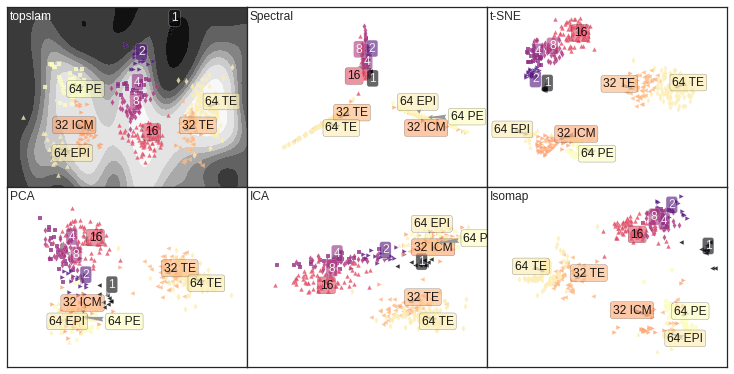

In [12]:
sns.set_style('white')
fig, axes = plot_comparison(mc, X_init, dims, labels.values, ulabels, start=begin)
#fig.tight_layout(pad=0, w_pad=.01, h_pad=.03, rect=(0,0,1,1))
fig.savefig('../diagrams/Guo/method_comparison.pdf', transparent=True, bbox_inches='tight')

## Plot time graphs

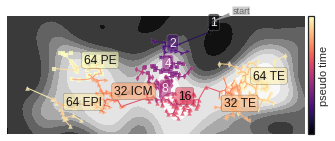

In [17]:
%run plot_definitions_datasets.py

fig, ax = plt.subplots(figsize=(5,2))

mc.plot_waddington_landscape(ax=ax)
mc.plot_graph_nodes(labels, ulabels, start=begin, ax=ax)
mc.plot_graph_labels(labels, ulabels, start=begin, ax=ax, box=True)
mc.plot_time_graph_edges(start=begin, ax=ax, startoffset=(20,10))

fig.tight_layout()
fig.savefig('../diagrams/Guo/Manifold_Tree.pdf', transparent=True, bbox_inches='tight')

In [ ]:
from scipy.spatial.distance import squareform, pdist
%run graph_extraction.py

In [ ]:
%run plot_definitions_datasets.py
# Wanderlust (without smoothing)

# take out tsne:
X = X_init[:,dims['t-SNE']].copy()

k = 4
start = 6

_, mst = extract_manifold_distances_mst(squareform(pdist(X)))
D, knn = extract_manifold_distances_knn(squareform(pdist(X)), knn=[k], add_mst=mst).next()
pt_graph = extract_distance_graph(D, knn, start)
G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(5,2))
plot_time_graph(G, X, pseudo_time, labels, ulabels, begin, (-30, -5), fig, ax)

fig.tight_layout()
fig.savefig('../diagrams/Guo/TSNE_knn.pdf', transparent=True, bbox_inches='tight')

## Plots for Talk (&Paper?)

In [41]:
cellstates = labels
ucellstates = ulabels
#cellstates = np.array([l.split(' ')[0] for l in labels])
#ucellstates = []
#for l in cellstates:
#    if l not in ucellstates:
#        ucellstates.append(l)
#ucellstates = np.array(ucellstates)

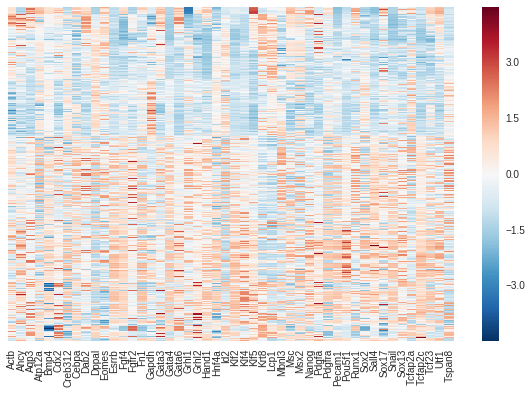

In [45]:
cat_labels = pd.Categorical(cellstates, categories=ucellstates)
colpal = sns.color_palette('rainbow', len(ucellstates))
rowcolors = np.array(sns.color_palette('rainbow', len(ucellstates)))[cat_labels.codes]

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(expr, ax=ax, yticklabels=False)
ax.figure.savefig('../diagrams/Guo/GE.pdf', transparent=True, bbox_inches='tight')

In [ ]:
cat_labels = pd.Categorical(cellstates, categories=ucellstates)
colpal = sns.color_palette('rainbow', len(ucellstates))
rowcolors = np.array(sns.color_palette('rainbow', len(ucellstates)))[cat_labels.codes]

ax = sns.clustermap(expr, figsize=(10,6), row_colors=rowcolors, yticklabels=False)
ax.ax_heatmap.figure.savefig('../diagrams/Guo/clustermap.pdf', transparent=True, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(1,10))
n = len(colpal)
import matplotlib as mpl
ax.imshow(np.arange(n).reshape(n, 1),
          cmap=mpl.colors.ListedColormap(list(colpal)),
          interpolation="nearest", aspect="auto")
ax.set_yticks(np.arange(n) - .5)
ax.set_xticks([-.5, .5])
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(len(ucellstates)):
    ax.text(0,i,ucellstates[i],ha='center', va='center', color='white')
ax.figure.savefig('../diagrams/Guo/clustermap_legend.pdf', transparent=True, bbox_inches='tight')